# 导入数据及转为array形式

In [1]:
import pandas as pd
import numpy as np

LassoClassificationFeature = pd.read_excel('./data/分类数据集.xlsx')
RandomForestLogisticsFeature = pd.read_excel('./data/回归数据集.xlsx')

tempArray_Lasso = np.array(LassoClassificationFeature)
tempArray_RandomForest = np.array(RandomForestLogisticsFeature)



# 半监督学习——分类

In [3]:
# coding:utf-8
import random
import numpy as np
import sklearn.svm as svm
from sklearn.datasets.samples_generator import make_classification
from sklearn.externals import joblib
import warnings; warnings.filterwarnings(action='ignore')

class TSVM(object):
    def __init__(self, kernel='linear'):
        self.Cl, self.Cu = 1.5, 0.001
        self.kernel = kernel
        self.clf = svm.SVC(C=1.5, kernel=self.kernel)

    def train(self, X1, Y1, X2):
        N = len(X1) + len(X2)
        # 样本权值初始化
        sample_weight = np.ones(N)
        sample_weight[len(X1):] = self.Cu

        # 用已标注部分训练出一个初始SVM
        self.clf.fit(X1, Y1)
        
        # 对未标记样本进行标记
        Y2 = self.clf.predict(X2)
        Y2 = Y2.reshape(-1,1)
        
        X = np.vstack([X1, X2])
        Y = np.vstack([Y1, Y2])
        
        # 未标记样本的序号
        Y2_id = np.arange(len(X2))
        
        while self.Cu < self.Cl:
            # 重新训练SVM, 之后再寻找易出错样本不断调整
            self.clf.fit(X, Y, sample_weight=sample_weight)
            while True:
                # print(X2)
                print(type(X2))
                Y2_decision = self.clf.decision_function(X2)   # 参数实例到决策超平面的距离
                Y2 = Y2.reshape(-1)
                print(len(Y2))
                print(Y2_decision)
                epsilon = 1 - Y2 * Y2_decision
                negative_max_id = Y2_id[epsilon==min(epsilon)]

                print(epsilon[negative_max_id][0])
                if epsilon[negative_max_id][0] > 0:
                    # 寻找很可能错误的未标记样本，改变它的标记成其他标记
                    pool = list(set(np.unique(Y1))-set(Y2[negative_max_id]))
                    Y2[negative_max_id] = random.choice(pool)
                    Y2 = Y2.reshape(-1, 1)
                    Y = np.vstack([Y1, Y2])
                    
                    self.clf.fit(X, Y, sample_weight=sample_weight)
                else:
                    break
            self.Cu = min(2*self.Cu, self.Cl)
            sample_weight[len(X1):] = self.Cu

    def score(self, X, Y):
        return self.clf.score(X, Y)

    def predict(self, X):
        return self.clf.predict(X)

    def save(self, path='./TSVM.model'):
        joblib.dump(self.clf, path)

    def load(self, model_path='./TSVM.model'):
        self.clf = joblib.load(model_path)

    def plot_confusion_matrix(self, X, Y):
        plot_confusion_matrix(self.clf,X,Y)

if __name__ == '__main__':
    tempArray = np.array(tempArray_Lasso)[:,:]

    #43很好
    split_num = 92

    #18效果还可以25：f1_score: 0.7692307692307692
    test_num = 25

    train_data = tempArray[test_num:split_num,5:]
    train_labels = np.array(np.array(tempArray)[test_num:split_num,4].astype(int)).reshape(-1,1)

    test_data = tempArray[:test_num,5:]
    test_labels = np.array(np.array(tempArray)[:test_num,4].astype(int)).reshape(-1,1)

    X2 = tempArray[split_num:,5:]
    Y2_labeled = np.array(np.array(tempArray)[split_num:,4].astype(int)).reshape(-1,1)

    model = TSVM()
    model.train(train_data, train_labels, X2)

    # Y2_hat = model.predict(X2)
    accuracy = model.score(test_data, test_labels)
    print(accuracy)
    
    pred = np.array(model.predict(test_data)).reshape(-1,1)

<class 'numpy.ndarray'>
46
[ 0.22347202 -0.92038551 -0.5052064  -3.50793109  0.98894961 -1.43996827
  1.29918489 -2.44446651 -0.66406514 -1.62671872 -3.8271347  -0.55194847
 -2.4060334  -1.10855959  1.03605312  4.04300685  0.00791735  0.43416164
 -1.25290907  0.87788098  1.1354146  -0.71589415 -0.23610922 -1.0681112
 -0.23672229 -0.40779877 -1.57817398 -1.91850113 -1.69464119 -4.77376236
 -1.787224   -1.74306764  0.08222825 -0.04381862  0.05447697 -1.96870947
  0.55548661 -1.58895646 -0.76496652 -0.03863266 -1.36009382 -0.62224519
  0.2969164  -2.21054324 -0.05537788 -1.90287054]
-3.0430068486119746
<class 'numpy.ndarray'>
46
[ 2.25939037e-01 -9.23644711e-01 -5.06357837e-01 -3.51335068e+00
  9.87271799e-01 -1.44255858e+00  1.30119816e+00 -2.44669160e+00
 -6.69254761e-01 -1.63000856e+00 -3.83099892e+00 -5.52145729e-01
 -2.40794130e+00 -1.10973463e+00  1.03486563e+00  4.04804747e+00
  4.73124811e-03  4.36107935e-01 -1.25482889e+00  8.75248325e-01
  1.13528119e+00 -7.14364108e-01 -2.37772

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# print(test_labels)
# print(pred)

print("accuracy_score:",precision_score(test_labels, pred))
print("precision_score:",precision_score(test_labels, pred))
print("recall_score:",recall_score(test_labels, pred))
print("f1_score:",f1_score(test_labels, pred))

accuracy_score: 0.8333333333333334
precision_score: 0.8333333333333334
recall_score: 0.7142857142857143
f1_score: 0.7692307692307692


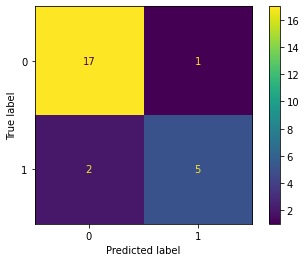

In [211]:
model.plot_confusion_matrix(test_data,test_labels)

# 半监督学习——回归任务

In [279]:
import numpy as np
import random
from sklearn.metrics import *
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


tempArray = np.array(tempArray_Lasso)[:,:]
print(len(tempArray))
data = tempArray[:,5:]

labels = np.array(tempArray)[:,3].astype(int)


split_num = 19

train_data = tempArray[split_num:,5:]
# np.save('X.npy',data)
# np.save('y.npy',labels)
train_labels = np.array(tempArray)[split_num:,3].astype(int)

# print(data)
masked_labels = np.array(tempArray)[:,3].astype(int)

# train_X,test_X,train_y,test_y = train_test_split(data,labels,test_size=0.2,random_state=4)

#RUN THE MODEL
model = LabelPropagation()
# model.fit(train_X, train_y)
model.fit(train_data,train_labels)
pred = np.array(model.predict(data))

# print(labels[masked_labels] == -1)

#SEPARATE PREDICTED SAMPLES
# labels = np.array(labels[masked_labels != -1]).astype(int)
# pred = pred[masked_labels != -1]

labels = np.array(tempArray)[:split_num,3].astype(int)
pred = pred[0:split_num]

print(len(pred))
print(labels)
print(pred)

print('Mean squared error: %.2f'
    % mean_squared_error(labels, pred))
print('Coefficient of determination: %.2f'
    % r2_score(labels, pred))


138
19
[18 16 16 20 13 15 11 17 25 22 17 17 16 17 16  8 18 15  8]
[19 12 18 20 10 11  7 21 16 25 12 12 16 11 21 12 15 15 12]
Mean squared error: 16.84
Coefficient of determination: -0.04


# 其余代码（过程中尝试，下面代码不用看）

> 縮排段落



In [ ]:
import numpy as np
import random

#RANDOMLY UNLABEL DATA CONSIDERING A PERCENTAGE
def maskData(true_labels, percentage):

    mask = np.ones((1,len(true_labels)),dtype=bool)[0]
    labels = true_labels.copy()
    
    for l, enc in zip(np.unique(true_labels),range(0,len(np.unique(true_labels)))):
        
        deck = np.argwhere(true_labels == l).flatten()        
        random.shuffle(deck)
        
        mask[deck[:int(percentage * len(true_labels[true_labels == l]))]] = False

        labels[labels == l] = enc

    labels[mask] = -1
    
    return np.array(labels).astype(int)

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import LabelPropagation

def runLP():
        
    #IMPORT DATASETS
    iris = datasets.load_iris()
    data = iris.data
    labels = iris.target

    # print(len(data))

    # print(data)
    print(len(labels))
    
    #UNLABEL 95% OF THE DATASET
    masked_labels = maskData(labels, 0.05)

    # print(type(masked_labels[0]))

    # print(len(data))
    print(len(masked_labels))

    #RUN THE MODEL
    model = LabelPropagation()
    model.fit(data, masked_labels)
    pred = np.array(model.predict(data))
    
    #SEPARATE PREDICTED SAMPLES
    labels = np.array(labels[masked_labels == -1]).astype(int)
    pred = pred[masked_labels == -1]
    
    #PRINT CONFUSION MATRIX
    print(confusion_matrix(labels, pred))
    
if __name__ == '__main__':
    runLP()

150
150
[[48  0  0]
 [ 0 48  0]
 [ 0 14 34]]


In [ ]:
import numpy as np
import random
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import train_test_split

tempArray = np.array(tempArray_Lasso)[:,:]
data = tempArray[:,5:]

labels = np.array(tempArray)[:,4].astype(int)

#43很好
split_num = 14

train_data = tempArray[split_num:,5:]
train_labels = np.array(tempArray)[split_num:,4].astype(int)

# print(data)
masked_labels = np.array(tempArray)[:,4].astype(int)

# train_X,test_X,train_y,test_y = train_test_split(data,labels,test_size=0.2,random_state=4)

#RUN THE MODEL
model = LabelPropagation()
# model.fit(train_X, train_y)
model.fit(train_data,train_labels)
pred = np.array(model.predict(data))

# print(labels[masked_labels] == -1)

#SEPARATE PREDICTED SAMPLES
# labels = np.array(labels[masked_labels != -1]).astype(int)
# pred = pred[masked_labels != -1]

labels = np.array(tempArray)[:split_num,4].astype(int)
pred = pred[0:split_num]

print(len(pred))
print(pred)

#PRINT CONFUSION MATRIX
print(confusion_matrix(labels, pred))

14
[1 0 0 1 0 0 0 1 0 1 0 0 0 0]
[[9 1]
 [1 3]]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(labels)
print(pred)

print("precision_score:",precision_score(labels, pred))
print("recall_score:",recall_score(labels, pred))
print("f1_score:",f1_score(labels, pred))

[1 0 0 1 0 0 0 0 1 1 0 0 0 0]
[1 0 0 1 0 0 0 1 0 1 0 0 0 0]
precision_score: 0.75
recall_score: 0.75
f1_score: 0.75


14
14
[[9 1]
 [1 3]]


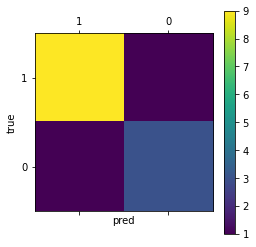

In [ ]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,roc_curve,auc,plot_roc_curve
import matplotlib.pyplot as plt

label = [0,1]
val = labels
print(len(val))
print(len(labels))
maxtrix = confusion_matrix(val, pred,labels=label)
print(maxtrix)
plt.matshow(maxtrix)
plt.colorbar()
plt.xlabel('pred')
plt.ylabel('true')
plt.xticks(np.arange(maxtrix.shape[1]),labels)
plt.yticks(np.arange(maxtrix.shape[1]),labels)
plt.show()

# 半监督学习——回归

In [ ]:
test = np.load("/content/X.npy")
print(len(test[0]))

16


In [ ]:
test = np.load("/content/XX.npy")
print(len(test[0]))

18


In [ ]:
test = np.load("/content/y.npy")
print(np.any(np.isnan(test)))
print(test)

False
[18. 16. 16. 20. 13. 15. 11. 17. 25. 22. 17. 17. 16. 17. 16.  8. 18. 15.
  8. 21. 12. 11.  9. 16. 18. 13. 17. 25. 15. 12.  7. 14. 21. 10. 14. 10.
 11. 13. 21. 21. 16. 23. 24. 16. 30. 17. 16. 20. 21. 15. 22. 22. 14. 20.
 11. 16. 22. 18. 19. 19. 27. 30. 19. 19. 16. 16. 28. 18. 12. 10. 23. 18.
 11. 15. 15.  9. 12. 11. 23. 14. 20. 18. 12. 14. 15. 15. 15. 16. 11. 12.
 12. 12. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


# github半监督回归尝试

In [ ]:
pip install numpy==1.16.2

     |████████████████████████████████| 17.3MB 249kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement numpy~=1.19.2, but you'll have numpy 1.16.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4


In [ ]:
import numpy as np
import os


def load_data(data_dir):
    """
    Loads data from data directory.
    """
    X = np.load(os.path.join(data_dir, 'X.npy'))
    y = np.load(os.path.join(data_dir, 'y.npy'))
    return X, y.reshape(-1, 1)

In [231]:
import numpy as np
from time import time
from scipy.spatial.distance import minkowski
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


class Coreg():
    """
    Instantiates a CoReg regressor.
    """
    def __init__(self, k1=3, k2=3, p1=2, p2=5, max_iters=100, pool_size=100):
        self.k1, self.k2 = k1, k2 # number of neighbors
        self.p1, self.p2 = p1, p2 # distance metrics
        self.max_iters = max_iters
        self.pool_size = pool_size
        self.h1 = KNeighborsRegressor(n_neighbors=self.k1, p=self.p1)
        self.h2 = KNeighborsRegressor(n_neighbors=self.k2, p=self.p2)
        self.h1_temp = KNeighborsRegressor(n_neighbors=self.k1, p=self.p1)
        self.h2_temp = KNeighborsRegressor(n_neighbors=self.k2, p=self.p2)

    def add_data(self, data_dir):
        """
        Adds data and splits into labeled and unlabeled.
        """
        self.X, self.y = load_data(data_dir)

    def run_trials(self, num_train=100, trials=10, verbose=False):
        """
        Runs multiple trials of training.
        """
        self.num_train = num_train
        self.num_trials = trials
        self._initialize_metrics()
        self.trial = 0
        while self.trial < self.num_trials:
            t0 = time()
            print('Starting trial {}:'.format(self.trial + 1))            
            self.train(random_state=(self.trial+self.num_train),
                num_labeled=self.num_train, num_test=1000, verbose=verbose,
                store_results=True)
            print('Finished trial {}: {:0.2f}s elapsed\n'.format(
                self.trial + 1, time() - t0))
            self.trial += 1

    def train(self, random_state=-1, num_labeled=100, num_test=1000,
        verbose=False, store_results=False):
        """
        Trains the CoReg regressor.
        """
        t0 = time()
        self._split_data(random_state, num_labeled, num_test)
        self._fit_and_evaluate(verbose)
        if store_results: self._store_results(0)
        self._get_pool()
        if verbose: print('Initialized h1, h2: {:0.2f}s\n'.format(time()-t0))
        for t in range(1, self.max_iters+1):
            stop_training = self._run_iteration(t, t0, verbose, store_results)
            if stop_training:
                if verbose:
                    print('Done in {} iterations: {:0.2f}s'.format(t, time()-t0))
                break
        if verbose: print('Finished {} iterations: {:0.2f}s'.format(t, time()-t0))

    def _run_iteration(self, t, t0, verbose=False, store_results=False):
        """
        Run t-th iteration of co-training, returns stop_training=True if
        no more unlabeled points are added to label sets.
        """
        stop_training = False
        if verbose: print('Started iteration {}: {:0.2f}s'.format(t, time()-t0))
        self._find_points_to_add()
        added = self._add_points()
        if added:
            self._fit_and_evaluate(verbose)
            if store_results:
                self._store_results(t)
            self._remove_from_unlabeled()
            self._get_pool()
        else:
            stop_training = True
        return stop_training

    def _add_points(self):
        """
        Adds new examples to training sets.
        """
        added = False
        if self.to_add['x1'] is not None:
            self.L2_X = np.vstack((self.L2_X, self.to_add['x1']))
            self.L2_y = np.vstack((self.L2_y, self.to_add['y1']))
            added = True
        if self.to_add['x2'] is not None:
            self.L1_X = np.vstack((self.L1_X, self.to_add['x2']))
            self.L1_y = np.vstack((self.L1_y, self.to_add['y2']))
            added = True
        return added

    def _compute_delta(self, omega, L_X, L_y, h, h_temp):
        """
        Computes the improvement in MSE among the neighbors of the point being
        evaluated.
        """
        delta = 0
        for idx_o in omega:
            delta += (L_y[idx_o].reshape(1, -1) -
                      h.predict(L_X[idx_o].reshape(1, -1))) ** 2
            delta -= (L_y[idx_o].reshape(1, -1) -
                      h_temp.predict(L_X[idx_o].reshape(1, -1))) ** 2
        return delta

    def _compute_deltas(self, L_X, L_y, h, h_temp):
        """
        Computes the improvements in local MSE for all points in pool.
        """
        deltas = np.zeros((self.U_X_pool.shape[0],))
        for idx_u, x_u in enumerate(self.U_X_pool):
            # Make prediction
            x_u = x_u.reshape(1, -1)
            y_u_hat = h.predict(x_u).reshape(1, -1)
            # Compute neighbors
            omega = h.kneighbors(x_u, return_distance=False)[0]
            # Retrain regressor after adding unlabeled point
            X_temp = np.vstack((L_X, x_u))
            y_temp = np.vstack((L_y, y_u_hat)) # use predicted y_u_hat
            h_temp.fit(X_temp, y_temp)
            delta = self._compute_delta(omega, L_X, L_y, h, h_temp)
            deltas[idx_u] = delta
        return deltas

    def _evaluate_metrics(self, verbose):
        """
        Evaluates KNN regressors on training and test data.
        """
        train1_hat = self.h1.predict(self.X_labeled)
        train2_hat = self.h2.predict(self.X_labeled)
        train_hat = 0.5 * (train1_hat + train2_hat)
        test1_hat = self.h1.predict(self.X_test)
        test2_hat = self.h2.predict(self.X_test)
        test_hat = 0.5 * (test1_hat + test2_hat)
        self.mse1_train = mean_squared_error(train1_hat, self.y_labeled)
        self.mse1_test = mean_squared_error(test1_hat, self.y_test)
        self.mse2_train = mean_squared_error(train2_hat, self.y_labeled)
        self.mse2_test = mean_squared_error(test2_hat, self.y_test)
        self.mse_train = mean_squared_error(train_hat, self.y_labeled)
        self.mse_test = mean_squared_error(test_hat, self.y_test)
        self.r2score1_train = r2_score(train1_hat, self.y_labeled)
        self.r2score1_test = r2_score(test1_hat, self.y_test)
        self.r2score2_train = r2_score(train2_hat, self.y_labeled)
        self.r2score2_test = r2_score(test2_hat, self.y_test)
        self.r2score_train = r2_score(train_hat, self.y_labeled)
        self.r2score_test = r2_score(test_hat, self.y_test)
        if verbose:
            print('MSEs:')
            print('  KNN1:')
            print('    Train: {:0.4f}'.format(self.mse1_train))
            print('    Test : {:0.4f}'.format(self.mse1_test))
            print('  KNN2:')
            print('    Train: {:0.4f}'.format(self.mse2_train))
            print('    Test : {:0.4f}'.format(self.mse2_test))
            print('  Combined:')
            print('    Train: {:0.4f}'.format(self.mse_train))
            print('    Test : {:0.4f}\n'.format(self.mse_test))
            print('r2-Scores:')
            print('  KNN1:')
            print('    Train: {:0.4f}'.format(self.r2score1_train))
            print('    Test : {:0.4f}'.format(self.r2score1_test))
            print('  KNN2:')
            print('    Train: {:0.4f}'.format(self.r2score2_train))
            print('    Test : {:0.4f}'.format(self.r2score2_test))
            print('  Combined:')
            print('    Train: {:0.4f}'.format(self.r2score_train))
            print('    Test : {:0.4f}\n'.format(self.r2score_test))

    def _find_points_to_add(self):
        """
        Finds unlabeled points (if any) to add to training sets.
        """
        self.to_add = {'x1': None, 'y1': None, 'idx1': None,
                       'x2': None, 'y2': None, 'idx2': None}
        # Keep track of added idxs
        added_idxs = []
        for idx_h in [1, 2]:
            if idx_h == 1:
                h = self.h1
                h_temp = self.h1_temp
                L_X, L_y = self.L1_X, self.L1_y
            elif idx_h == 2:
                h = self.h2
                h_temp = self.h2_temp
                L_X, L_y = self.L2_X, self.L2_y
            deltas = self._compute_deltas(L_X, L_y, h, h_temp)
            # Add largest delta (improvement)
            sort_idxs = np.argsort(deltas)[::-1] # max to min
            max_idx = sort_idxs[0]
            if max_idx in added_idxs: max_idx = sort_idxs[1]
            if deltas[max_idx] > 0:
                added_idxs.append(max_idx)
                x_u = self.U_X_pool[max_idx].reshape(1, -1)
                y_u_hat = h.predict(x_u).reshape(1, -1)
                self.to_add['x' + str(idx_h)] = x_u
                self.to_add['y' + str(idx_h)] = y_u_hat
                self.to_add['idx' + str(idx_h)] = self.U_idx_pool[max_idx]

    def _fit_and_evaluate(self, verbose):
        """
        Fits h1 and h2 and evaluates metrics.
        """
        self.h1.fit(self.L1_X, self.L1_y)
        self.h2.fit(self.L2_X, self.L2_y)
        self._evaluate_metrics(verbose)

    def _get_pool(self):
        """
        Gets unlabeled pool and indices of unlabeled.
        """
        self.U_X_pool, self.U_y_pool, self.U_idx_pool = shuffle(
            self.U_X, self.U_y, range(self.U_y.size))
        self.U_X_pool = self.U_X_pool[:self.pool_size]
        self.U_y_pool = self.U_y_pool[:self.pool_size]
        self.U_idx_pool = self.U_idx_pool[:self.pool_size]

    def _initialize_metrics(self):
        """
        Sets up metrics to be stored.
        """
        initial_metrics = np.full((self.num_trials, self.max_iters+1), np.inf)
        self.mses1_train = np.copy(initial_metrics)
        self.mses1_test = np.copy(initial_metrics)
        self.mses2_train = np.copy(initial_metrics)
        self.mses2_test = np.copy(initial_metrics)
        self.mses_train = np.copy(initial_metrics)
        self.mses_test = np.copy(initial_metrics)

    def _remove_from_unlabeled(self):
        # Remove added examples from unlabeled
        to_remove = []
        if self.to_add['idx1'] is not None:
            to_remove.append(self.to_add['idx1'])
        if self.to_add['idx2'] is not None:
            to_remove.append(self.to_add['idx2'])
        self.U_X = np.delete(self.U_X, to_remove, axis=0)
        self.U_y = np.delete(self.U_y, to_remove, axis=0)

    def _split_data(self, random_state=-1, num_labeled=100, num_test=1000):
        """
        Shuffles data and splits it into train, test, and unlabeled sets.
        """
        if random_state >= 0:
            self.X_shuffled, self.y_shuffled, self.shuffled_indices = shuffle(
                self.X, self.y, range(self.y.size), random_state=random_state)
        else:
            self.X_shuffled = self.X[:]
            self.y_shuffled = self.y[:]
            self.shuffled_indices = range(self.y.size)
        # Initial labeled, test, and unlabeled sets
        test_end = num_labeled + num_test
        self.X_labeled = self.X_shuffled[:num_labeled]
        self.y_labeled = self.y_shuffled[:num_labeled]
        self.X_test = self.X_shuffled[num_labeled:test_end]
        self.y_test = self.y_shuffled[num_labeled:test_end]
        self.X_unlabeled = self.X_shuffled[test_end:]
        self.y_unlabeled = self.y_shuffled[test_end:]
        # Up-to-date training sets and unlabeled set
        self.L1_X = self.X_labeled[:]
        self.L1_y = self.y_labeled[:]
        self.L2_X = self.X_labeled[:]
        self.L2_y = self.y_labeled[:]
        self.U_X = self.X_unlabeled[:]
        self.U_y = self.y_unlabeled[:]

    def _store_results(self, iteration):
        """
        Stores current MSEs.
        """
        self.mses1_train[self.trial,iteration] = self.mse1_train
        self.mses1_test[self.trial,iteration] = self.mse1_test
        self.mses2_train[self.trial,iteration] = self.mse2_train
        self.mses2_test[self.trial,iteration] = self.mse2_test
        self.mses_train[self.trial,iteration] = self.mse_train
        self.mses_test[self.trial,iteration] = self.mse_test

In [233]:
import numpy as np


data_dir = '/content'
k1 = 8
k2 = 8
p1 = 2
p2 = 5
max_iters = 100
pool_size = 100
verbose = True
random_state = -1
num_labeled = 80
num_test = 10

cr = Coreg(k1, k2, p1, p2, max_iters, pool_size)
cr.add_data(data_dir)

# Run training
num_train = 10
trials = 3
verbose = True
cr.run_trials(num_train, trials, verbose)

Starting trial 1:
MSEs:
  KNN1:
    Train: 33.1344
    Test : 26.5903
  KNN2:
    Train: 33.5719
    Test : 25.8841
  Combined:
    Train: 33.2750
    Test : 26.0553

r2-Scores:
  KNN1:
    Train: -88.7039
    Test : -44.3044
  KNN2:
    Train: -84.1268
    Test : -63.6284
  Combined:
    Train: -103.1879
    Test : -79.3246

Initialized h1, h2: 0.01s

Started iteration 1: 0.01s


IndexError: ignored

25
25
[[17  1]
 [ 2  5]]


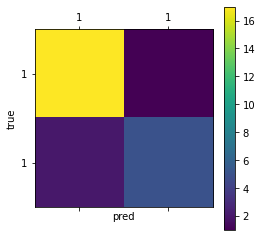

In [191]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,roc_curve,auc,plot_roc_curve
import matplotlib.pyplot as plt

label = [0,1]
val = test_labels
print(len(test_labels))
print(len(pred))
maxtrix = confusion_matrix(test_labels, pred,labels=label)
print(maxtrix)
plt.matshow(maxtrix)
plt.colorbar()
plt.xlabel('pred')
plt.ylabel('true')
plt.xticks(np.arange(maxtrix.shape[1]),labels)
plt.yticks(np.arange(maxtrix.shape[1]),labels)
plt.show()

# 回归

In [292]:
# coding:utf-8
import random
import numpy as np
import sklearn.svm as svm
from sklearn.datasets.samples_generator import make_classification
from sklearn.externals import joblib
import warnings; warnings.filterwarnings(action='ignore')

class TSVM(object):
    def __init__(self, kernel='linear'):
        self.Cl, self.Cu = 1.5, 0.001
        self.kernel = kernel
        self.clf = svm.SVC(C=1.5, kernel=self.kernel)

    def train(self, X1, Y1, X2):
        N = len(X1) + len(X2)
        # 样本权值初始化
        sample_weight = np.ones(N)
        sample_weight[len(X1):] = self.Cu

        # 用已标注部分训练出一个初始SVM
        self.clf.fit(X1, Y1)
        
        # 对未标记样本进行标记
        Y2 = self.clf.predict(X2)
        Y2 = Y2.reshape(-1,1)
        
        X = np.vstack([X1, X2])
        Y = np.vstack([Y1, Y2])
        
        # 未标记样本的序号
        Y2_id = np.arange(len(X2))
        
        while self.Cu < self.Cl:
            # 重新训练SVM, 之后再寻找易出错样本不断调整
            self.clf.fit(X, Y, sample_weight=sample_weight)
            while True:
                # print(type(X2))
                Y2_decision = self.clf.decision_function(X2)   # 参数实例到决策超平面的距离
                Y2 = Y2.reshape(-1)
                # print(Y2)
                # print(Y2_decision)
                epsilon = 1 - Y2*Y2_decision
                print(epsilon)
                negative_max_id = Y2_id[epsilon==min(epsilon)]

                print(epsilon[negative_max_id][0])
                if epsilon[negative_max_id][0] > 0:
                    # 寻找很可能错误的未标记样本，改变它的标记成其他标记
                    pool = list(set(np.unique(Y1))-set(Y2[negative_max_id]))
                    Y2[negative_max_id] = random.choice(pool)
                    Y2 = Y2.reshape(-1, 1)
                    Y = np.vstack([Y1, Y2])
                    
                    self.clf.fit(X, Y, sample_weight=sample_weight)
                else:
                    break
            self.Cu = min(2*self.Cu, self.Cl)
            sample_weight[len(X1):] = self.Cu

    def score(self, X, Y):
        return self.clf.score(X, Y)

    def predict(self, X):
        return self.clf.predict(X)

    def save(self, path='./TSVM.model'):
        joblib.dump(self.clf, path)

    def load(self, model_path='./TSVM.model'):
        self.clf = joblib.load(model_path)

    def plot_confusion_matrix(self, X, Y):
        plot_confusion_matrix(self.clf,X,Y)

if __name__ == '__main__':
    tempArray = np.array(tempArray_RandomForest)[:,:]

    #43很好
    split_num = 92

    train_data = tempArray[17:split_num,5:]
    train_labels = np.array(np.array(tempArray)[17:split_num,3].astype(int)).reshape(-1,1)

    test_data = tempArray[:17,5:]
    test_labels = np.array(np.array(tempArray)[:17,3].astype(int)).reshape(-1,1)

    X2 = tempArray[split_num:,5:]
    Y2_labeled = np.array(np.array(tempArray)[split_num:,3].astype(int)).reshape(-1,1)

    model = TSVM()
    model.train(train_data, train_labels, X2)

    # Y2_hat = model.predict(X2)
    accuracy = model.score(test_data, test_labels)
    print(accuracy)
    
    pred = np.array(model.predict(test_data)).reshape(-1,1)

ValueError: ignored